In [1]:
'''ULS vs TOPAZ
'''



import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc4
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from src.utils import modif_plot
from src.utils import save_name
from src.utils import tardisml_utils
from src.utils import cmap_manip
from src.data_preparation import load_data
from src.data_preparation import merge_TOPAZ
from src.data_preparation import colocalise_buoys
from src.data_preparation import running_mean as rm
from src.modelling import sit_corrected

In [2]:
def getfile_uls_BPEG(idir='', ifile='', buoy='a'):
    '''
    Parameters:
    -----------
        buoy     :   string, name of the buoy. 'a', 'b', 'c', 'd'
    '''

    if idir == '':
        idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_BGEP/netcdf/'
    if ifile == '':
        ifile = f'uls{buoy.upper()}_2003_2018.nc'

    return f'{idir}{ifile}'

In [3]:
def getfile_uls_NPEO(idir='', ifile='', buoy=''):
    '''Import NPEO buoy (only one)
    '''
    if idir == '':
        idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_NPEO/netcdf/'
    if ifile == '':
        ifile = 'uls_NPEO_2001_2008.nc'
        
    return f'{idir}{ifile}'
    

In [4]:
def getfile_uls_ADCP(idir='', ifile='', buoy='Khatanga'):
    '''Import ADCP buoys
    Parameters:
    -----------
    
        buoy     :   string, name/place of the buoy.
                     can be: 'Anabar', 'Khatanga', 'Lena', 'OuterShelf'
    
    '''
    import glob
    
    if idir == '':
        idir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/ADCP_Transdrift/netcdf/'
    if ifile == '':
        # glob the file
        ifile = f'adcp_Transdrift_{buoy}*.nc'
        ifile = glob.glob(f'{idir}{ifile}')[0]
    
    return f'{ifile}'
    

In [5]:
def getfile_uls_Fram(idir='', ifile='', buoy=''):
    '''Import Fram buoys
    '''
    
    print('Nothing here..')
    
    return f'{idir}{ifile}'
    

In [6]:
def import_uls(ifile):
    '''
    Return sea ice thickness, SIT standard deviation, latitude, longitude and time
    
    ADCP only have daily values >> no standard deviation
    
    Parameters:
    -----------
        ifile     :   string, absolute path of the .nc file to open
    '''
    nc = nc4.Dataset(f'{ifile}', mode='r')
    sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit']
    
    if 'ADCP' in ifile:
        sit_std = None
    else:
        sit_std = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit_std']

    lat = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['lat']
    lon = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['lon']

    chrono = pd.DataFrame({'date':pd.to_datetime(sit.time)})

    chrono_dt_uls = np.array([dt.date() for dt in chrono.date])
    
    return sit, sit_std, lat, lon, chrono_dt_uls

In [7]:
def smooth_uls(sit, sit_std, ndays=7, buoy_type=''):
    '''Smooth with a running mean
    
    Parameters:
    -----------
        sit      : xarray.DataArray, Sea ice thickness
        sit_std  : xarray.DataArray, SIT standard deviation
        ndays    : int, number of days for the running window
    '''

    # smoothing
    sit_smooth = np.array(rm.center_running_mean(sit.to_numpy(), ndays, npd=1))

    # Convert numpy to xarray
    sit_sm = xr.DataArray(
        data=sit_smooth,
        dims=["time"],
        coords=dict(
            time=(['time'], sit.time.data)
        ),
        attrs=dict(
            standard_name='sit',
            description="SIT with averaging window over 1 week",
            long_name='mean sea ice thickness',
            unit='m',
            ULS=f'{buoy_type}'
        ),)

    if sit_std is None:  # observation might not have standard deviation
        return sit_sm, None

    sit_std_smooth = np.array(rm.center_running_mean(sit_std.to_numpy(), ndays, npd=1))
    
    sit_std_sm = xr.DataArray(
        data=sit_std_smooth,
        dims=["time"],
        coords=dict(
            time=(['time'], sit_std.time.data)
        ),
        attrs=dict(
            standard_name='sit',
            description="SIT with averaging window over 1 week",
            long_name='std sea ice thickness',
            unit='m',
            ULS=f'{buoy_type}'
        ),)

    return sit_sm, sit_std_sm

In [8]:
def draw_sit_uls(chrono_dt_uls, sit_uls, sit_std_uls, 
                 valid_ll, sit_na_loc, sit_bl_loc, sit_ml_loc,
                 buoy='', rootdir='', savefig=False, showfig=False):

    
    # detect if there is a gap in chrono
    increment_days = chrono_dt_uls[1:]-chrono_dt_uls[:-1]  # number of days between 2 dates
    mask_gap = np.array([x.days>1 for x in increment_days] + [False])

    sit_plt = sit_uls.copy()
    sit_na_loc_plt = sit_na_loc.copy()
    sit_bl_loc_plt = sit_bl_loc.copy()
    sit_ml_loc_plt = sit_ml_loc.copy()

    if np.any(mask_gap):
        sit_plt[mask_gap] = np.nan
        sit_na_loc_plt[mask_gap[valid_ll]] = np.nan
        sit_bl_loc_plt[mask_gap[valid_ll]] = np.nan
        sit_ml_loc_plt[mask_gap[valid_ll]] = np.nan
    

    date_first_uls = chrono_dt_uls[0]
    date_last_uls = chrono_dt_uls[-1]

    date_min = date_first_uls - datetime.timedelta(days=30) # datetime.datetime(2011,1,1)
    date_max = date_last_uls + datetime.timedelta(days=30) # datetime.datetime(2020,1,1)
#     date_max = datetime.datetime(2010,12,31)

    odir = f'{rootdir}Leo/results/ULS_BGEP/'
    ofile = f'uls{buoy.upper()}_SIT_TOPAZ_{date_min.year}_{date_max.year}_01.png'
    
    
    # -----------------   Plot -------------------------------------
    fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)

    # ULS
    plt.plot(chrono_dt_uls, sit_plt, c='k', ls='--', lw=2, label=f'ULS {buoy.upper()}')
    if sit_std_uls is not None:
        plt.fill_between(chrono_dt_uls, sit_uls+sit_std_uls, sit_uls-sit_std_uls, color='grey', alpha=0.2, where=~mask_gap)

    # TOPAZ
    plt.plot(chrono_dt_uls[valid_ll], sit_na_loc_plt, label='TOPAZ freerun', c='#1295B2')
    plt.plot(chrono_dt_uls[valid_ll], sit_bl_loc_plt, label='Baseline', c='#7E8A8A')
    plt.plot(chrono_dt_uls[valid_ll], sit_ml_loc_plt, label='ML-adjusted', c='#FB6949', lw=2)

    ax.set_ylim([0, 5])
    if buoy == 'NPEO':
        ax.set_ylim([0, 7])
        
    ax.set_xlim([date_min, date_max])


    ax.set_ylabel('SIT (m)')
    ax.set_title(f'Mooring {buoy.upper()}')
    plt.legend(fontsize=18, ncol=4)
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.grid(alpha=0.6)

    modif_plot.resize(fig, s=24, rx=-20)

    if savefig:
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=200, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')

    

In [9]:
def compute_seasonal_errors(sit_ml_locDA, sit_bl_locDA, sit_uls):
    '''Compute Bias/RMSE/Corr
    
    Parameters:
    -----------
        sit_ml_locDA      : xarray.DataArray, Sea ice thickness TOPAZ ML-adjusted colocated with ULS
        sit_bl_locDA      : xarray.DataArray, Sea ice thickness TOPAZ baseline colocated with ULS
        sit_uls           : xarray.DataArray, SIT ULS
    '''

    seasons = ['DJF', 'MAM', 'JJA', 'SON']


    sits_ml = sit_ml_locDA.groupby('time.season')
    sits_bl = sit_bl_locDA.groupby('time.season')
    sits_uls = sit_uls.groupby('time.season')
    # DataArrayGroupBy, grouped over 'season'
    # 4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.


    bias_season = np.array([(sits_ml[saison] - sits_uls[saison]).mean() for saison in seasons])
    rmse_season = np.array([np.sqrt((np.square(sits_ml[saison] - sits_uls[saison])).mean()) for saison in seasons])
    corr_season = np.array([xr.corr(sits_ml[saison], sits_uls[saison]) for saison in seasons])

    biasm = bias_season.mean()
    rmsem = rmse_season.mean()
    corrm = corr_season.mean()

    # ---------------

    bias_bl_season = np.array([(sits_bl[saison] - sits_uls[saison]).mean() for saison in seasons])
    rmse_bl_season = np.array([np.sqrt((np.square(sits_bl[saison] - sits_uls[saison])).mean()) for saison in seasons])
    corr_bl_season = np.array([xr.corr(sits_bl[saison], sits_uls[saison]) for saison in seasons])

    biasm_bl = bias_bl_season.mean()
    rmsem_bl = rmse_bl_season.mean()
    corrm_bl = corr_bl_season.mean()


    # --------------- Print results  -------------------------------------


    print(f'\n\nULS {buoy.upper()}:    [ML-adjusted - ULS] \n')
    print('mean Bias    |      mean  RMSE   |   mean corr')
    print(f'{biasm:.03f}                {rmsem:.03f}            {corrm:.03f}')

    print('\n\tDJF     |   MAM     |    JJA      |    SON   ')
    print(f'Bias\t{bias_season[0]:.03f}      {bias_season[1]:.03f} \
          {bias_season[2]:.03f}        {bias_season[3]:.03f}')

    print(f'RMSE\t{rmse_season[0]:.03f}      {rmse_season[1]:.03f} \
          {rmse_season[2]:.03f}        {rmse_season[3]:.03f}')

    print(f'Corr\t{corr_season[0]:.03f}      {corr_season[1]:.03f} \
          {corr_season[2]:.03f}        {corr_season[3]:.03f}')



    print(f'\n\nULS {buoy.upper()}:    [Baseline - ULS] \n')
    print('mean Bias    |      mean  RMSE    |    corr')
    print(f'{biasm_bl:.03f}                {rmsem_bl:.03f}            {corrm_bl:.03f}')

    print('\n\tDJF     |   MAM     |    JJA      |    SON   ')
    print(f'Bias\t{bias_bl_season[0]:.03f}      {bias_bl_season[1]:.03f} \
          {bias_bl_season[2]:.03f}        {bias_bl_season[3]:.03f}')


    print(f'RMSE\t{rmse_bl_season[0]:.03f}      {rmse_bl_season[1]:.03f} \
          {rmse_bl_season[2]:.03f}        {rmse_bl_season[3]:.03f}')

    print(f'Corr\t{corr_bl_season[0]:.03f}      {corr_bl_season[1]:.03f} \
          {corr_bl_season[2]:.03f}        {corr_bl_season[3]:.03f}')

In [10]:
from scipy import stats
def compute_errors(sit_ml_loc, sit_bl_loc, sit, print_latex=False):
    '''Compute Bias/RMSE/Corr on average
    '''
    
    # corr between sit[valid_ll] and sit_ml_loc
#     x = sit[valid_ll]
#     y = sit_ml_loc

#     x = sit[valid_ll]
#     y = sit_bl_loc

    # remove nan
    tp_ml = sit_ml_loc[~np.isnan(sit)]  # topaz
    ref = sit[~np.isnan(sit)]  # reference = obs
    tp_bl = sit_bl_loc[~np.isnan(sit)]  # topaz
    
    c_val_ml, p_val_ml = stats.pearsonr(tp_ml, ref)  # returns correlation value, p value
    rmse_ml = np.sqrt((np.square(tp_ml-ref)).mean())
    bias_ml = (tp_ml - ref).mean()
    
    c_val_bl, p_val_bl = stats.pearsonr(tp_bl, ref)  # returns correlation value, p value
    rmse_bl = np.sqrt((np.square(tp_bl-ref)).mean())
    bias_bl = (tp_bl - ref).mean()

    print('\n\nML-adjusted - ULS')
    print(f'bias  :      {bias_ml.data:.03f}')
    print(f'rmse  :      {rmse_ml.data:.03f}')
    print(f'mean corr:   {c_val_ml:.03f}     p value:    {p_val_ml:.06f}')

    
    print('\n\nBaseline - ULS')
    print(f'bias  :      {bias_bl.data:.03f}')
    print(f'rmse  :      {rmse_bl.data:.03f}')
    print(f'mean corr:   {c_val_bl:.03f}     p value:    {p_val_bl:.06f}')    
    
    if print_latex:
        print('\nLatex table:')
        print(f'{bias_ml.data:.03f} ({bias_bl.data:.03f}) & {rmse_ml.data:.03f} ({rmse_bl.data:.03f}) & {c_val_ml:.03f} ({c_val_bl:.03f})\\')
    

In [11]:
# -----------------------------------------------


rootdir = tardisml_utils.get_rootdir()

In [12]:
# -------------- Get ULS filename ------------------------

buoy_type = 'BGEP'  # 'BGEP' / 'NPEO' / 'ADCP' / 'Fram'

if buoy_type == 'BGEP':
    buoy = 'd'  # 'a', 'b', 'c', 'd'
    ifile = getfile_uls_BPEG(idir='', ifile='', buoy=buoy)

if buoy_type == 'NPEO':
    ifile = getfile_uls_NPEO()
    
if buoy_type == 'ADCP':
    buoy = 'Lena'  # 'Anabar', 'Khatanga', 'Lena', 'OuterShelf'
    ifile = getfile_uls_ADCP(buoy=buoy)
    
if buoy_type == 'Fram':
    ifile = getfile_uls_Fram()    

In [13]:
ifile

'/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_BGEP/netcdf/ulsD_2003_2018.nc'

In [20]:
# -------------- Import ULS A SIT ------------------------

sit_uls, sit_std_uls, lat_A, lon_A, chrono_dt_uls = import_uls(ifile='/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_BGEP/netcdf/ulsA_2003_2018.nc')
sit_smA, sit_std_sm = smooth_uls(sit_uls, sit_std_uls, ndays=7, buoy_type=buoy_type)

/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:40: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[i-window_size//2:i+window_size//2])
/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:49: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[-idx:-1])


In [21]:
# -------------- Import ULS B SIT ------------------------

sit_uls, sit_std_uls, lat_B, lon_B, chrono_dt_uls = import_uls(ifile='/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_BGEP/netcdf/ulsB_2003_2018.nc')
sit_smB, sit_std_sm = smooth_uls(sit_uls, sit_std_uls, ndays=7, buoy_type=buoy_type)

/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:40: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[i-window_size//2:i+window_size//2])
/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:49: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[-idx:-1])


In [22]:
# -------------- Import ULS C SIT ------------------------

sit_uls, sit_std_uls, lat_C, lon_C, chrono_dt_uls = import_uls(ifile='/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_BGEP/netcdf/ulsC_2003_2018.nc')
sit_smC, sit_std_sm = smooth_uls(sit_uls, sit_std_uls, ndays=7, buoy_type=buoy_type)

/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:49: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[-idx:-1])


In [23]:
# -------------- Import ULS D SIT ------------------------

sit_uls, sit_std_uls, lat_D, lon_D, chrono_dt_uls = import_uls(ifile='/scratch/project_465000269/edelleo1/Leo/SIT_observations/ULS_BGEP/netcdf/ulsD_2003_2018.nc')
sit_smD, sit_std_sm = smooth_uls(sit_uls, sit_std_uls, ndays=7, buoy_type=buoy_type)

/users/edelleo1/tardis/tardis-ml/src/data_preparation/running_mean.py:49: RuntimeWarning: Mean of empty slice
  window_average = np.nanmean(arr[-idx:-1])


In [28]:
lat_A

<xarray.DataArray 'lat' (time: 6569)>
array([75.000139, 75.000139, 75.000139, ..., 74.983604, 74.983604, 74.983604])
Coordinates:
  * time     (time) datetime64[ns] 2003-08-14 2003-08-15 ... 2021-08-28
Attributes:
    name:     latitude
    unit:     North

In [25]:
lats = np.array([lat_A, lat_B, lat_C, lat_D])
lons = np.array([lon_A, lon_B, lon_C, lon_D])

/tmp/ipykernel_205473/2772937951.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lats = np.array([lat_A, lat_B, lat_C, lat_D])
/tmp/ipykernel_205473/2772937951.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lons = np.array([lon_A, lon_B, lon_C, lon_D])


In [26]:
lats

array([<xarray.DataArray 'lat' (time: 6569)>
       array([75.000139, 75.000139, 75.000139, ..., 74.983604, 74.983604, 74.983604])
       Coordinates:
         * time     (time) datetime64[ns] 2003-08-14 2003-08-15 ... 2021-08-28
       Attributes:
           name:     latitude
           unit:     North                                                           ,
       <xarray.DataArray 'lat' (time: 5708)>
       array([78.016803, 78.016803, 78.016803, ..., 77.983523, 77.983523, 77.983523])
       Coordinates:
         * time     (time) datetime64[ns] 2003-08-24 2003-08-25 ... 2021-04-25
       Attributes:
           name:     latitude
           unit:     North                                                           ,
       <xarray.DataArray 'lat' (time: 1806)>
       array([76.983398, 76.983398, 76.983398, ..., 76.983556, 76.983556, 76.983556])
       Coordinates:
         * time     (time) datetime64[ns] 2003-08-27 2003-08-28 ... 2008-08-09
       Attributes:
           name:   

In [30]:
from src.utils import quickplot

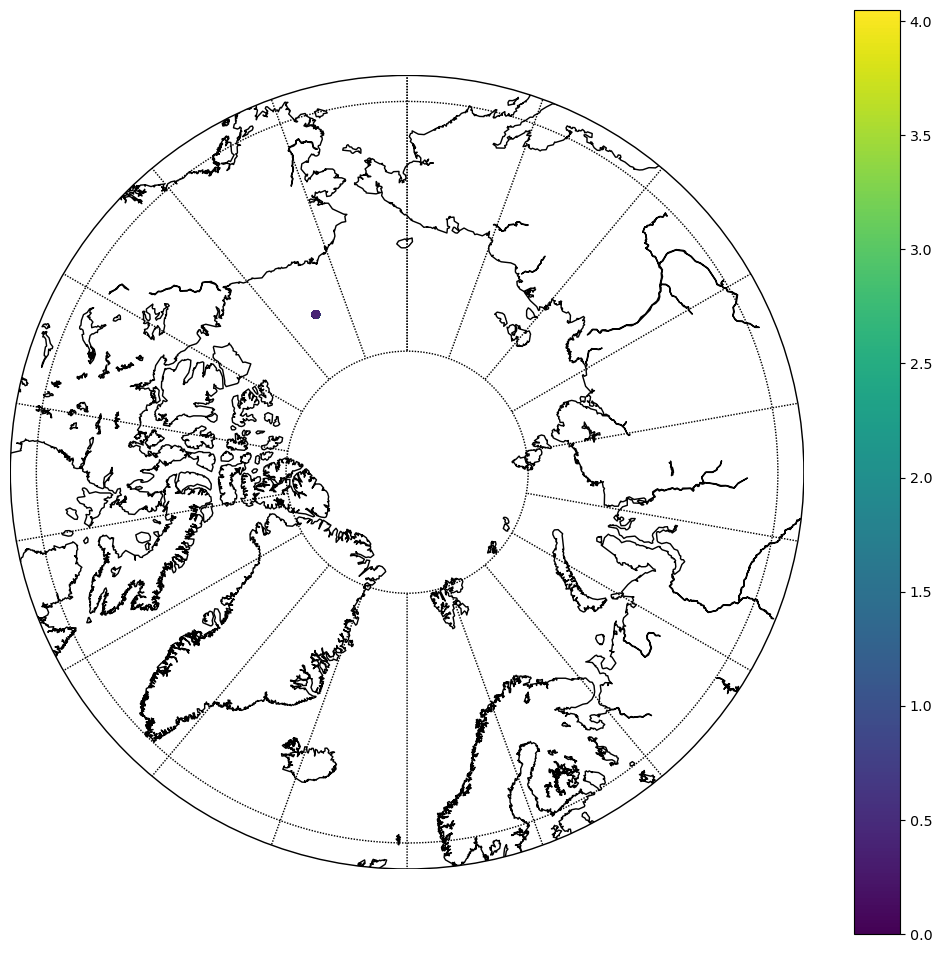

In [33]:
quickplot.basemap(lon_A, lat_A, sit_smA)

In [36]:
from mpl_toolkits.basemap import Basemap

AttributeError: 'Basemap' object has no attribute 'annotate'

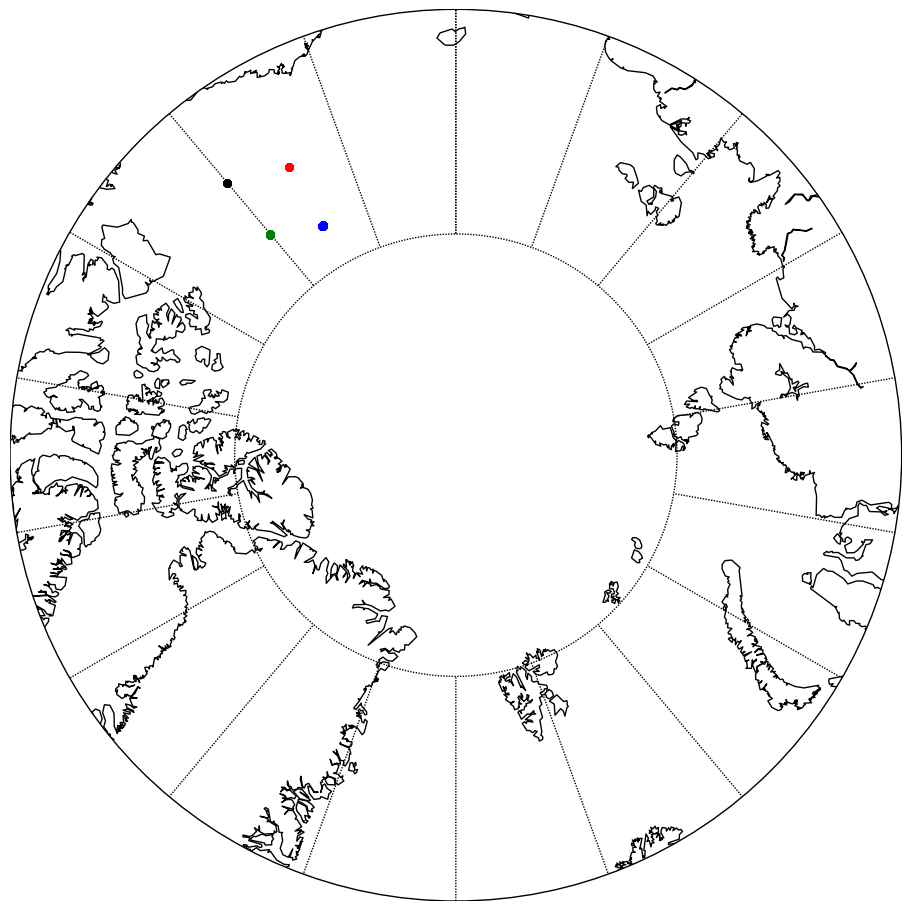

In [41]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 9), constrained_layout=True)

# ---- SIT ----

m = Basemap(projection='npstere', boundinglat=70, lon_0=0, resolution='l', round=True)
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.scatter(lon_A, lat_A, c='r', lw=0, latlon=True, zorder=10)
m.scatter(lon_B, lat_B, c='b', lw=0, latlon=True, zorder=10)
m.scatter(lon_C, lat_C, c='g', lw=0, latlon=True, zorder=10)
m.scatter(lon_D, lat_D, c='k', lw=0, latlon=True, zorder=10)
m.annotate(lon_D[0], lat_D[0], c='k', lw=0, latlon=True, zorder=10)

In [8]:
# -------------- Import TOPAZ ------------------------

ipath = 'Leo/results/lstm_230919-170402/'
ml_name ='LSTM'

ifile = f'{rootdir}{ipath}'
m2000 = sit_corrected.SITCorrected(ifile, name=ml_name, verbose=0, objective='apply')

#  Reconstruct SIT values 
m2000.reconstruct_sit()
m2000.compute_mean(sic_min=0.15)

sit_ml = m2000.sit
sit_na = m2000.sit_na
sit_bl = m2000.sit_bl

chrono_dt_ml = np.array([dt.date() for dt in m2000.chrono.date])

# Cap negative value at 0 m (while keeping nan)
sit_ml = (sit_ml.where((0<sit_ml), 0)).where(np.isfinite(sit_ml))

In [144]:
# -------------- Colocate TOPAZ to ULS (time/space) ------------------------

sit_ml_loc, lats, lons, valid_ll = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_ml, chrono_dt_ml)
sit_na_loc, _, _, _ = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_na, chrono_dt_ml)
sit_bl_loc, _, _, _ = colocalise_buoys.get_closest_arr(lat, lon, chrono_dt_uls, sit_bl, chrono_dt_ml)

sit_ml_locDA = xr.DataArray(sit_ml_loc, 
                coords={'time': sit_uls.time[valid_ll]},
                dims=["time"])
sit_bl_locDA = xr.DataArray(sit_bl_loc, 
                coords={'time': sit_uls.time[valid_ll]},
                dims=["time"])

Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/ULS_BGEP/ulsLENA_SIT_TOPAZ_2003_2004_02.png


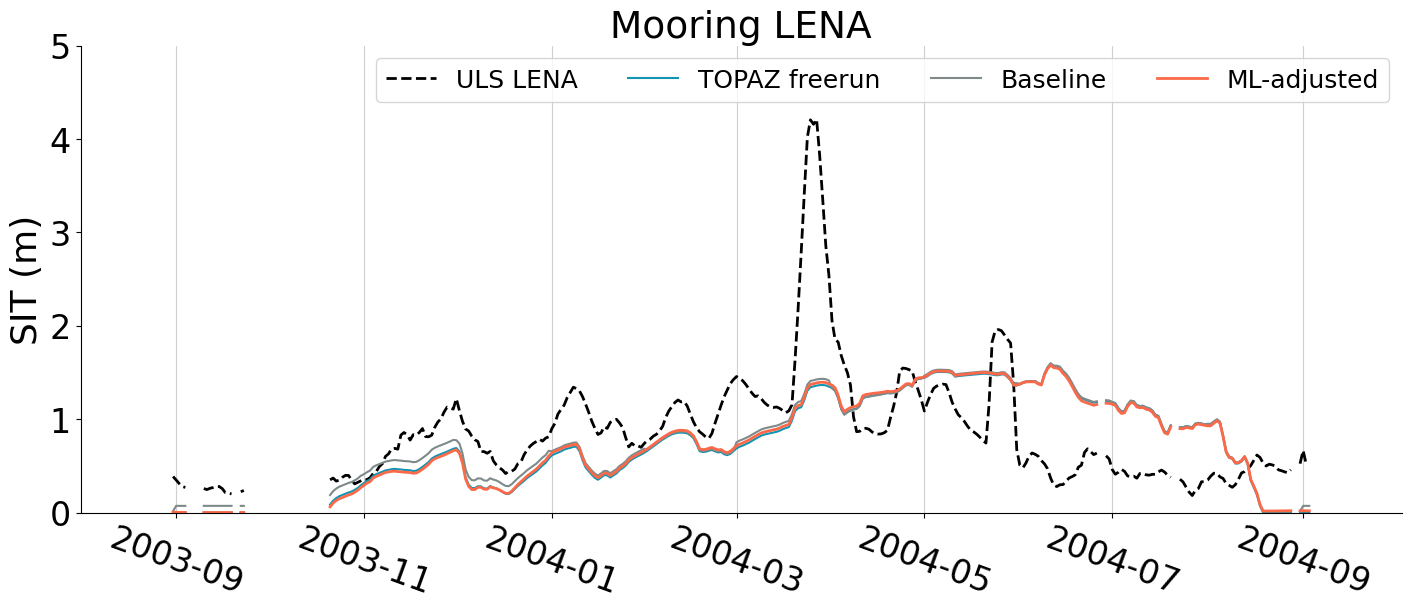

In [153]:
# -------------- Plot ------------------------

draw_sit_uls(chrono_dt_uls, sit_sm, sit_std_sm, 
             valid_ll, sit_na_loc, sit_bl_loc, sit_ml_loc,
             buoy=buoy, rootdir=rootdir, savefig=True, showfig=True)

In [140]:
# ----------------- Compute Bias/RMSE/Corr -----------------------

compute_errors(sit_ml_loc, sit_bl_loc, sit_sm[valid_ll], print_latex=True)

# compute_seasonal_errors(sit_ml_locDA, sit_bl_locDA, sit_uls)



ML-adjusted - ULS
bias  :      -1.241
rmse  :      1.389
mean corr:   0.863     p value:    0.000000


Baseline - ULS
bias  :      -1.256
rmse  :      1.441
mean corr:   0.814     p value:    0.000000

Latex table:
-1.241 (-1.256) & 1.389 (1.441) & 0.863 (0.814)\
